In [0]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 

import cv2
import pickle as pkl

import os

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!cp /content/drive/My\ Drive/GP/DSP2_Classwork/DSP\ final\ project/Datasets\ DSP-2\ Image\ Recognition\ Project-20200507T043015Z-001.zip /content


In [0]:
!unzip /content/Datasets\ DSP-2\ Image\ Recognition\ Project-20200507T043015Z-001.zip


Archive:  /content/Datasets DSP-2 Image Recognition Project-20200507T043015Z-001.zip
replace Datasets DSP-2 Image Recognition Project/Test_numbers.PNG? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
# function to load data from pickle files
def load_pkl(path):
  with open(path, 'rb') as f:
    return pkl.load(f)

In [0]:
# load training data 
train_images = load_pkl('/content/Datasets DSP-2 Image Recognition Project/train_dsp_images.pkl')
train_labels = load_pkl('/content/Datasets DSP-2 Image Recognition Project/train_dsp_labels.pkl')


In [0]:
# load validation data
validation_images = load_pkl('/content/Datasets DSP-2 Image Recognition Project/val_dsp_images.pkl')
validation_labels = load_pkl('/content/Datasets DSP-2 Image Recognition Project/val_dsp_labels.pkl')

In [0]:
#load test data
test_images = load_pkl('/content/Datasets DSP-2 Image Recognition Project/test_dsp_images.pkl')
test_labels = load_pkl('/content/Datasets DSP-2 Image Recognition Project/test_dsp_labels.pkl')

In [0]:
# Number of Our classes
NUM_CLASSES = 10

# Fixed for Dataset color images
CHANNELS = 3

IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 50
EARLY_STOP_PATIENCE = 4

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# NOTE that these BATCH* are for Keras ImageDataGenerator batching to fill epoch step input
BATCH_SIZE_TRAINING = 128
BATCH_SIZE_VALIDATION = 128

# Using 1 to easily manage mapping between test_generator & prediction for submission preparation
BATCH_SIZE_TESTING = 1

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]


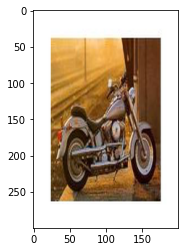

In [0]:
# sample of the data
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
print(train_images[123])
imgplot = plt.imshow(train_images[123])

In [0]:
# check labels type (Do we need to encode it?)
print (test_labels[0])
print (train_labels[0])
print (validation_labels[0])

Motorbikes
Motorbikes
Motorbikes


In [0]:
# So we need to encode the labels
# Function One hot encoder
# First Encode them then apply one hot encoder

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

def One_Hot_Encoder(labels):
  encoded_labels = np.array(labels)
  labelencoder_X = LabelEncoder()
  encoded_labels = labelencoder_X.fit_transform(encoded_labels)
  encoded_labels = np.expand_dims(np.array(encoded_labels),axis=1)
  onehotencoder = OneHotEncoder(categories='auto')
  encoded_labels = onehotencoder.fit_transform(encoded_labels).toarray()
  return encoded_labels

In [0]:
# Encode the training, validation and test labels
train_labels = One_Hot_Encoder(train_labels)
validation_labels = One_Hot_Encoder(validation_labels)
test_labels = One_Hot_Encoder(test_labels)

In [0]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout



In [0]:
import tensorflow as tf
model = Sequential()

# 1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
# NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is
model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = 'imagenet'))
# 2nd layer as Dense for 10-class classification.
model.add(Dense(512, activation = tf.nn.relu))
model.add(Dropout(0.2))

model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))

# Say not to train first layer (ResNet) model as it is already trained
model.layers[0].trainable = False

94773248/94765736 [==============================] - 3s 0us/step


In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 24,641,930
Trainable params: 1,054,218
Non-trainable params: 23,587,712
_________________________________________________________________


In [0]:
from tensorflow.keras import optimizers

Adamm = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer = Adamm, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

In [0]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = '/content/best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [0]:
# concatenate validation images and labels into one variable to pass it into model.fit
validation = (validation_images, validation_labels)
print (validation[0])

[[[[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [255 255 255]
   [255 255 255]
   [255 255 255]]

  [[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [255 255 255]
   [255 255 255]
   [255 255 255]]

  [[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [255 255 255]
   [255 255 255]
   [255 255 255]]

  ...

  [[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [255 255 255]
   [255 255 255]
   [255 255 255]]

  [[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [255 255 255]
   [255 255 255]
   [255 255 255]]

  [[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [255 255 255]
   [255 255 255]
   [255 255 255]]]


 [[[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [255 255 255]
   [255 255 255]
   [255 255 255]]

  [[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [255 255 255]
   [255 255 255]
   [255 255 255]]

  [[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [255 255 255]
   [255 255 255]
   [255 255

In [0]:
fit_history = model.fit(
        train_images,
        train_labels,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = NUM_EPOCHS,
        validation_data=validation,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        callbacks=[cb_checkpointer, cb_early_stopper]
)
model.load_weights("/content/best.hdf5")

Epoch 1/50
10/10 [==============================] - 20s 2s/step - loss: 0.9557 - accuracy: 0.7287 - val_loss: 0.1577 - val_accuracy: 0.9542
Epoch 2/50
10/10 [==============================] - 11s 1s/step - loss: 0.1292 - accuracy: 0.9586 - val_loss: 0.1207 - val_accuracy: 0.9542
Epoch 3/50
10/10 [==============================] - 11s 1s/step - loss: 0.0562 - accuracy: 0.9817 - val_loss: 0.0682 - val_accuracy: 0.9730
Epoch 4/50
10/10 [==============================] - 11s 1s/step - loss: 0.0306 - accuracy: 0.9919 - val_loss: 0.0545 - val_accuracy: 0.9757
Epoch 5/50
10/10 [==============================] - 11s 1s/step - loss: 0.0240 - accuracy: 0.9942 - val_loss: 0.0614 - val_accuracy: 0.9730
Epoch 6/50
10/10 [==============================] - 12s 1s/step - loss: 0.0175 - accuracy: 0.9963 - val_loss: 0.0519 - val_accuracy: 0.9838
Epoch 7/50
10/10 [==============================] - 11s 1s/step - loss: 0.0132 - accuracy: 0.9976 - val_loss: 0.0573 - val_accuracy: 0.9757
Epoch 8/50
10/10 [==

In [0]:
scores = model.evaluate(test_images, test_labels, verbose=0)
scores

[0.10801038146018982, 0.9808219075202942]